In [1]:
import torch
from torchvision import datasets, transforms
import torch.optim as optim
from matplotlib import pyplot as plt
import torch.nn as nn

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size of ddh dataset 50000
Size of ddh validation dataset 10000


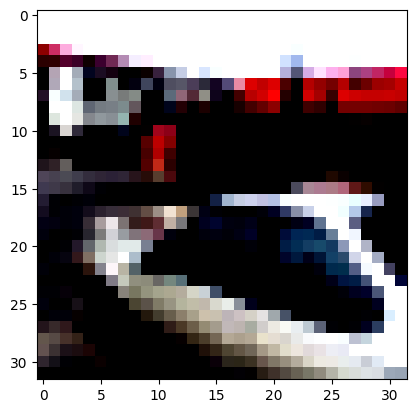

In [2]:
# Download CIFAR 10 dataset for training and validation purposes and apply the following changes on each image:
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

# 1) make it a tensor

# 2) normalize it based on the mean and standard deviation among all pixels in each channel (RGB).
transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])

cifar10 = datasets.CIFAR10(
    data_path, 
    train=True, 
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465],
                             [0.2470, 0.2435, 0.2616])
]))

cifar10_val = datasets.CIFAR10(
    data_path, 
    train=False, 
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465],
                             [0.2470, 0.2435, 0.2616])
]))

# Print the size of training and validation datasets
print("Size of ddh dataset", len(cifar10))
print("Size of ddh validation dataset", len(cifar10_val))

# Plot the last training image
plt.imshow(cifar10[-1][0].permute(1, 2, 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size of cifar2 training set 15000
Size of cifar2 validation set 3000


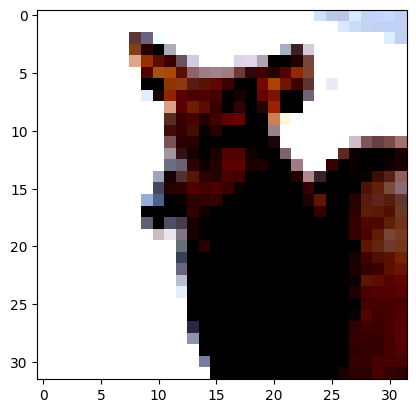

In [3]:
# We want to make a tertiary classifier that distinguishes between deers, dogs, and horses, labeled as 4, 5, and 7, resp.
# Create the subset training and validation datasets for this purpose.
label_map = {4: 0, 5: 1, 7: 2}
class_names = ['deers', 'dogs', 'horses']
ddh = [(img, label_map[label])
          for img, label in cifar10 if label in label_map.keys()]

ddh_val = [(img, label_map[label])
             for img, label in cifar10_val if label in label_map.keys()]

# Print the size of these datasets.
print("Size of cifar2 training set", len(ddh))
print("Size of cifar2 validation set", len(ddh_val))

# Plot the last training image
plt.imshow(ddh[-1][0].permute(1, 2, 0))

In [4]:
# Create a NN consisting of 
# 1) a linear layer that receives appropriate number of input features and outputs 1024 features, followed by hyperbolic
#    tangent as the activation function,
# 2) a linear layer that receives appropriate number of input features and outputs 256 features, followed by hyperbolic
#    tangent as the activation function,
# 3) the final linear layer with appropriate input and output number of features, followed by logarithm of softmax

model = nn.Sequential(
    nn.Linear(3072, 1024), # 1024 total pixels per image * 3 channels (RGB) = 3072
    nn.Tanh(),
    nn.Linear(1024, 256),
    nn.Tanh(),
    nn.Linear(256, len(class_names)),
    nn.LogSoftmax(dim=1)
)

# Print total number of exisiting parameters in the NN with respect to which gradient of loss must be computed.
print(model)


Sequential(
  (0): Linear(in_features=3072, out_features=1024, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1024, out_features=256, bias=True)
  (3): Tanh()
  (4): Linear(in_features=256, out_features=3, bias=True)
  (5): LogSoftmax(dim=1)
)


In [5]:
# Our training functionality is supposed to compute gradient on batches of training data, randlomy selected each time.
# To this end, create a training data loader with batch size 32 that randomizes access to each batch.
train_loader = torch.utils.data.DataLoader(
    ddh,
    batch_size=32,
    shuffle=True
)

# Also, create a validation data loader with the same batch size that does not randomize access to each batch (no need!)
val_loader = torch.utils.data.DataLoader(
    ddh_val,
    batch_size=32,
    shuffle=False
)

# Print the number of batches in training and validation data loaders
print("Training loader batches", len(train_loader))
print("Validation loader batches", len(val_loader))

# Print the size of the last batch in each of the training and validation loaders (they are not necessarily 32)
for imgs, _ in train_loader:
    last_size = imgs.shape[0]
print("Size of last train_loader:", last_size)

for imgs, _ in val_loader:
    last_size = imgs.shape[0]
print("Size of last val_loader:", last_size)

Training loader batches 469
Validation loader batches 94
Size of last train_loader: 24
Size of last val_loader: 24


In [6]:
# Define your training function that receives the data loaders, model, loss function, optimizer, and number of epochs.
# In each epoch, you should go through each training data batch, and:
# 1) compute the output batch, and accordingly the loss
# 2) compute the gradient of loss wrt parameters, and update the parameters
# After covering all epochs, your training function must report
# 1) the training accuracy, and
# 2) the validation accuracy

def training_loop(train_loader, val_loader, model, loss_fn, optimizer, n_epochs):
    for epoch in range(n_epochs):
        for imgs, labels in train_loader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("Epoch: %d, Loss %f" %(epoch, float(loss)))
        
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    
    print("Correct:", correct)
    print("Total:", total)
    print(f"Accuracy: {correct / total}")

        

In [ ]:
# Call the training function on the created data loaders, the created NN, negative log likelihood loss function, 
# stochastic gradient descent optimizer, and 100 epochs.

training_loop(train_loader, 
              val_loader,
              model,
              loss_fn=nn.NLLLoss(),
              optimizer=optim.SGD(model.parameters(), lr=1e-2),
              n_epochs=100
)

# Is the model overfit for this problem? (Yes/No) Why?
# The model overfits it becasue the accuracy is too low 
# whereas on the training data, it is higher

Epoch: 0, Loss 0.912790
Epoch: 1, Loss 0.992440
Epoch: 2, Loss 0.936567
Epoch: 3, Loss 0.750141
Epoch: 4, Loss 0.879342
Epoch: 5, Loss 0.822120
Epoch: 6, Loss 0.756098
Epoch: 7, Loss 0.583484
Epoch: 8, Loss 0.650451
Epoch: 9, Loss 0.644157
Epoch: 10, Loss 0.624996
Epoch: 11, Loss 0.636276
Epoch: 12, Loss 0.511445
Epoch: 13, Loss 0.522120
Epoch: 14, Loss 0.433540
Epoch: 15, Loss 0.581718
Epoch: 16, Loss 0.285179
Epoch: 17, Loss 0.510565
Epoch: 18, Loss 0.414859
Epoch: 19, Loss 0.269843
Epoch: 20, Loss 0.221838
Epoch: 21, Loss 0.211036
Epoch: 22, Loss 0.205107
Epoch: 23, Loss 0.197908
Epoch: 24, Loss 0.224606
Epoch: 25, Loss 0.132160
Epoch: 26, Loss 0.070642
Epoch: 27, Loss 0.045133
Epoch: 28, Loss 0.032452
Epoch: 29, Loss 0.012635
Epoch: 30, Loss 0.013521
Epoch: 31, Loss 0.039079
Epoch: 32, Loss 0.009809
Epoch: 33, Loss 0.014616
Epoch: 34, Loss 0.005687
Epoch: 35, Loss 0.010409
Epoch: 36, Loss 0.004805
Epoch: 37, Loss 0.004039
Epoch: 38, Loss 0.013528
Epoch: 39, Loss 0.005573
Epoch: 40,